# Shopify Challenge


## Question 1

At Shopify, we have precisely 100 sneaker shops, and each of these shops sells only one model of shoe. We want to analyze the average order value (AOV). When looking at order data over a 30-day window, we naively calculate an AOV of &#36;3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis.

In [1]:
# import necessary packages

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# set the scene
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### The Dataset

The dataset is taken from [this link](https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0) provided by Shopify challenge description.

The dataset consists of 5000 entries with no missing values. Therefore, there is no need to think of the ways of imputations. All entries represent values for a single month from March 1 to March 30, 2017. Since there is a datetime instance, we can convert it on the fly for easier manipulation.

In [2]:
# load dataset
shopify = pd.read_csv('data/2019 Winter Data Science Intern Challenge Data Set - Sheet1.csv',
                      parse_dates=['created_at'], index_col=0)

# set type to "category"
shopify['payment_method'] = shopify['payment_method'].astype('category')

# verify there are no missing values
shopify.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   shop_id         5000 non-null   int64         
 1   user_id         5000 non-null   int64         
 2   order_amount    5000 non-null   int64         
 3   total_items     5000 non-null   int64         
 4   payment_method  5000 non-null   category      
 5   created_at      5000 non-null   datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(4)
memory usage: 239.4 KB


In [3]:
# check first instances
shopify.head(3)

,shop_id,user_id,order_amount,total_items,payment_method,created_at
order_id,,,,,,
1,53,746,224,2,cash,2017-03-13 12:36:56
2,92,925,90,1,cash,2017-03-03 17:38:52
3,44,861,144,1,cash,2017-03-14 04:23:56


In [4]:
# check the dates
dates = shopify['created_at']
print(f'Min date: {dates.min()}\nMax date: {dates.max()}\nDifference: {dates.max() - dates.min()}')

Min date: 2017-03-01 00:08:09
Max date: 2017-03-30 23:55:35
Difference: 29 days 23:47:26


Just reading the description of the assignment already states that the AOV number is ridiculously high. Indeed, sneakers are something that anyone could afford, but giving away over &#36;3000 on average is just wrong. We need to look into the descriptive statistics to get the first insights.

After a careful analysis, it became evident what was causing the problem. First of all, AOV is a naive way of calculating the mean of the column, there is nothing fancy going on there. However, we should always be cautious about the “mean” behavior. It gets dragged around fiercely in case of outliers. A quick overview and descriptive statistics can give the first steps into the investigation.

In [5]:
shopify.describe()

,shop_id,user_id,order_amount,total_items
count,5000.000000,5000.000000,5000.000000,5000.00000
mean,50.078800,849.092400,3145.128000,8.78720
std,29.006118,87.798982,41282.539349,116.32032
min,1.000000,607.000000,90.000000,1.00000
25%,24.000000,775.000000,163.000000,1.00000
50%,50.000000,849.000000,284.000000,2.00000
75%,75.000000,925.000000,390.000000,3.00000
max,100.000000,999.000000,704000.000000,2000.00000


The above shows the descriptive statistics for the numeric values of the dataset. Here we can see a couple of interesting points about the order_amount and total_items columns:
1. The average (mean) value of the order_amount column is &#36;3,145.13 as given in the dataset description, so now we know where the number came from.

2. The standard deviation of the order_amount column is &#36;41,282.54 which indicates that the dataset has a high variation. Looking at the quantiles shows that the main spread is within &#36;90 to &#36;390 which is more believable than the price given above.

3. The same behavior is observed for the total_items column. The average (mean) value is almost 9. This means that people buy almost 9 pairs of shoes in one go which is clearly wrong. Moreover, we can see the maximum value of 2,000 items per order. This could be the wholesale buyers which should be treated differently in a separate dataset.

### Exploratory Data Analysis

The above code revealed high variance. We need to see which shops are dragging the whole dataset's metrics. For starters, we need to verify that there are indeed 100 stores. After the verification, we will use boxplot and kdeplots to get the distribution insights. Of course, here we will answer the three questions:
- Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.
- What metric would you report for this dataset?
- What is its value?

For fun, we will also check the price, total purchase, and frequency of buying. It will also be interesting to see the TOP places and check whether selling them for less drives the overall revenue.



In [6]:
# verify the number of stores
print('Number of unique stores:', shopify.shop_id.nunique())

Number of unique stores: 100


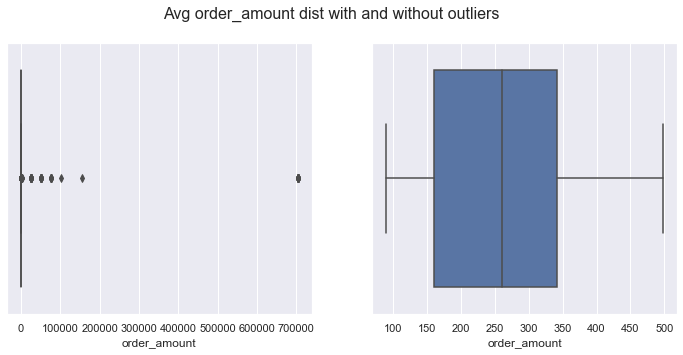

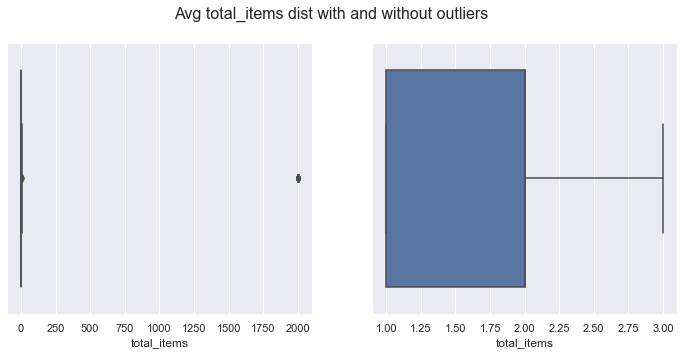

In [7]:
def side_by_side(df, col, thresh):
    outlier = df[df[col] > thresh]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Avg {col} dist with and without outliers', fontsize=16)
    sns.boxplot(data=df, x=col, ax=ax[0])
    sns.boxplot(data=df.drop(index=outlier.index, axis='rows'), x=col, ax=ax[1])
    plt.show()

# visualize distributions
side_by_side(shopify, 'order_amount', 500)
side_by_side(shopify, 'total_items',  3)

### Think about what could be going wrong with our calculation. Think about a better way to evaluate this data.

The average (mean) value is not sufficient for the dataset. There are two solutions that can be employed. First, store the outliers separately and double-check with the shops (#42 and #78) for the correctness of data acquisition. Second, we can drop the values and move on with the analysis.
Why would we need to store the outliers separately? Below we can see that there are 17 orders with 2,000 items that brought &#36;704,000 per order in shop #42. Another shop #78 also made 19 successful transactions of &#36;25,725. Since the numbers are not single-instance cases, we should definitely look closer into them!

In [8]:
data = shopify.groupby('shop_id').agg({'order_amount': ['mean', 'min', 'max'], 'total_items': ['count', 'mean']})
data.columns = ['usd_mean', 'usd_min', 'usd_max', 'n_items', 'n_mean']
data.sort_values(['usd_mean', 'n_mean'], ascending=False)

,usd_mean,usd_min,usd_max,n_items,n_mean
shop_id,,,,,
42,235101.490196,352,704000,51,667.901961
78,49213.043478,25725,154350,46,1.913043
50,403.545455,193,965,44,2.090909
90,403.224490,178,890,49,2.265306
38,390.857143,190,760,35,2.057143
...,...,...,...,...,...
53,214.117647,112,560,68,1.911765
100,213.675000,111,444,40,1.925000
32,189.976190,101,404,42,1.880952


In [9]:
# separate outliers from the dataset
indices     = shopify['shop_id'].isin([42, 78])
outliers    = shopify[indices]
no_outliers = shopify[~indices]

# show new AOV values (MEAN)
print(f'AOV of the dataset with outliers: ${format(shopify.order_amount.mean(), ".2f")}')
print(f'AOV of the dataset without outliers: ${format(no_outliers.order_amount.mean(), ".2f")}')
print(f'AOV of outlier shops (#42 & #78): ${format(outliers.order_amount.mean(), ".2f")}')

AOV of the dataset with outliers: $3145.13
AOV of the dataset without outliers: $300.16
AOV of outlier shops (#42 & #78): $146948.21


In [10]:
# show new AOV values (MEDIAN)
print(f'AOV of the dataset with outliers: ${format(shopify.order_amount.median(), ".2f")}')
print(f'AOV of the dataset without outliers: ${format(no_outliers.order_amount.median(), ".2f")}')
print(f'AOV of outlier shops (#42 & #78): ${format(outliers.order_amount.median(), ".2f")}')

AOV of the dataset with outliers: $284.00
AOV of the dataset without outliers: $284.00
AOV of outlier shops (#42 & #78): $25725.00


In [11]:
# show outliers' orders and their occurrences
temp = outliers.groupby('shop_id')[['order_amount', 'total_items']].value_counts().reset_index()
temp.columns = ['shop_id', 'order_amount', 'items_per_order', 'count']
temp

,shop_id,order_amount,items_per_order,count
0,42,704000,2000,17
1,42,352,1,15
2,42,704,2,13
3,42,1056,3,3
4,42,1408,4,2
5,42,1760,5,1
6,78,25725,1,19
7,78,51450,2,16
8,78,77175,3,9
9,78,102900,4,1


### What metric would you report for this dataset? & What is its value?

If we store the outliers separately, we can use the same AOV formula which will result in a more-or-less adequate value of &#36;300.16. However, if we cannot separate the values, we can simply switch to the median value. It’s less prone to getting dragged around unlike the mean. In both cases with and without outliers, the AOV is &#36;284.

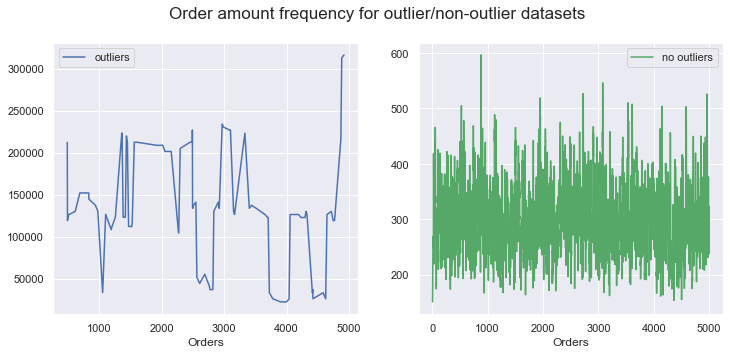

In [12]:
# show the shop order frequencies for outliers/non-outliers
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# set title
fig.suptitle('Order amount frequency for outlier/non-outlier datasets', fontsize=17)

# show frequencies
outliers.rolling(7).mean().plot(y='order_amount', ax=ax[0], label='outliers')
shopify[~shopify['shop_id'].isin([42, 78])].rolling(7).mean().plot(y='order_amount', ax=ax[1], label='no outliers', color='g')

# set titles
ax[0].set_xlabel('Orders')
ax[1].set_xlabel('Orders')
plt.show()

## Question 2

For this question, you’ll need to use SQL. Follow this link to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

- How many orders were shipped by Speedy Express in total?
To get the total number of orders, we need to investigate the Shipper dataset and get the ShipperID for “Speedy Express”. Then, we can simply use COUNT function to get the value.
```
SELECT COUNT(OrderID) FROM Orders
WHERE ShipperID = 1
```

**Answer**: 54

- What is the last name of the employee with the most orders?
This information can be easily found using GROUP BY and ORDER BY in descending order. The logic is the following: get the last name of each employee and count their occurrence in the Orders table while naming the new variable for further usage. For this purpose, it’s named `num_orders`. Then, we order the occurrences in descending order and limit the results to show only one person.

```
SELECT e.LastName, COUNT(*) as num_orders FROM Employees as e
JOIN ORDERS as o ON e.EmployeeID = o.EmployeeID
GROUP BY e.LastName
ORDER BY num_orders DESC
LIMIT 1
```

**Answer**: Peacock

- What product was ordered the most by customers in Germany?
This question can be answered with two different approaches. First, if we select the most popular product by its occurrence without calculating the total items within the order. Here we would calculate the most popular product that customers order. To do that, we will need to find:
1. Customers from Germany only
```
SELECT CustomerID FROM Customers
WHERE Country = 'Germany'
```

2. Select orders from Germany
```
SELECT o.OrderID FROM Orders as o
JOIN Customers as c ON o.CustomerID = c.CustomerID
WHERE c.CustomerID IN
    (
        SELECT CustomerID FROM Customers
        WHERE Country = 'Germany'
    )
```

3. The most popular product in the OrderDetails table
```
SELECT ProductID, COUNT(*) as total FROM OrderDetails
GROUP BY ProductID
ORDER BY total DESC
LIMIT 1
```

4. Name and description of the most popular product
```
SELECT DISTINCT p.ProductID, p.ProductName FROM Products as p
JOIN OrderDetails as o ON p.ProductID = o.ProductID
WHERE p.ProductID IN (
      SELECT ProductID FROM (
        SELECT ProductID, COUNT(*) as total FROM OrderDetails
        GROUP BY ProductID
        ORDER BY total DESC
        LIMIT 1)
      )
```

5. Combine everything together
```
SELECT DISTINCT p.ProductID, p.ProductName FROM Products as p
JOIN OrderDetails as o ON p.ProductId = o.ProductID
WHERE o.OrderID in (
    SELECT o.OrderID FROM Orders as o
    JOIN Customers as c ON o.CustomerID = c.CustomerID
    WHERE c.CustomerID IN (
        SELECT CustomerID FROM Customers
        WHERE Country = 'Germany'
    )
) AND p.ProductID IN (
    SELECT ProductID FROM (
        SELECT ProductID, COUNT(*) as total FROM OrderDetails
        GROUP BY ProductID
        ORDER BY total DESC
        LIMIT 1
        )
    )
```

**Answer**: Mozzarella di Giovanni is the most popular item by OrderID


---

The second option is to look at the quantity-wise selling points. Thus, we will get the most popular items by their quantity.

```
SELECT p.ProductName, SUM(o.Quantity) AS total, c.Country
FROM Products as p
JOIN OrderDetails AS o ON p.ProductID = o.ProductID
JOIN Orders AS ord ON ord.OrderID = o.OrderID
JOIN Customers AS c ON c.CustomerID = ord.CustomerID
WHERE c.Country = "Germany"
GROUP BY p.ProductName
ORDER BY total DESC
LIMIT 1;
```

**Answer**: Boston Crab Meat is the most popular item by quantity